In [192]:
# model that predicts the highest value of volatility (VIX) that will be reached in the next 60 days (excluding weekends)
from tvDatafeed import TvDatafeed, Interval
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np



In [193]:
tv = TvDatafeed()
vix = tv.get_hist(symbol="VIX", exchange="CBOE", interval=Interval.in_daily, n_bars=50000)
vix.to_csv('out.csv')

In [194]:
column_names = ['datetime','symbol','open','high','low','close','volume']
dataframe = pd.read_csv("out.csv", header=0)
dataframe['close'] = dataframe['close'].clip(upper=40)

Text(0.5, 1.0, 'VIX Values')

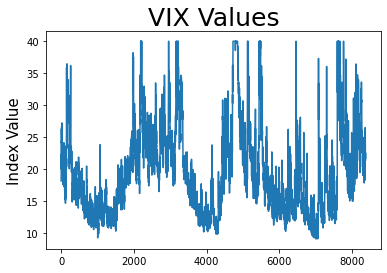

In [195]:
close_data = dataframe['close']
close_data.plot(x="Index Value", y="Step")
plt.ylabel("Index Value", size=15)
plt.title("VIX Values", size=25)

In [196]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    print(str(data_mean) + " mean")
    print(str(data_std) + " std")
    return (data - data_mean) / data_std, data_mean, data_std


In [197]:
split_ratio = 0.80
train_split = int(split_ratio*close_data.shape[0])
features, meann, stdd = normalize(close_data, train_split)
features = pd.DataFrame(features)
train_length = 180
validation_length = 60
learning_rate= 0.010
step=1
batch_size = 64

19.528144420549566 mean
6.883455521448023 std


<AxesSubplot:>

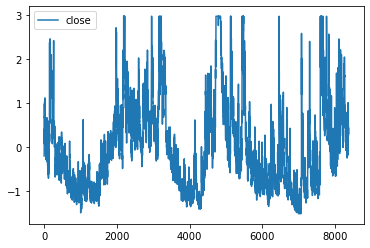

In [198]:
features.plot()

<AxesSubplot:>

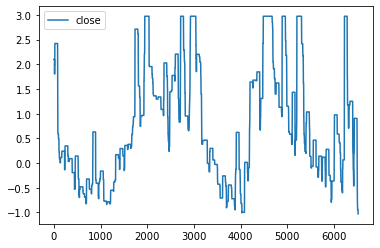

In [199]:
train_data = features.loc[:train_split-1]
validation_data = features.loc[train_split:]

#Model takes first 180 days and predicts the highest value that will be reached in the next 60 days (excluding weekends)
train_mean_target = []

for i in range(train_length, train_split):
    max_value = train_data[i:i+validation_length].max() #max value in the next 60 days
    train_mean_target.append(max_value)

train_mean_target = pd.DataFrame(train_mean_target)
train_mean_target.plot()

In [200]:
data_train = keras.preprocessing.timeseries_dataset_from_array(
    data=train_data,
    targets=train_mean_target,
    sequence_length=train_length,
    sampling_rate=step,
    batch_size=batch_size
)

In [201]:
validation_mean_target = []

for i in range(train_length, len(validation_data) - validation_length):
    max_value = validation_data[i:i + validation_length].max()
    validation_mean_target.append(max_value)

<AxesSubplot:>

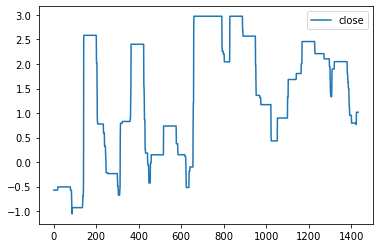

In [202]:
validation_mean_target = pd.DataFrame(validation_mean_target)
validation_mean_target.plot()

In [203]:
data_train_validation = keras.preprocessing.timeseries_dataset_from_array(
    data=validation_data,
    targets=validation_mean_target,
    sequence_length=train_length,
    sampling_rate=step,
    batch_size = batch_size
)

In [204]:
for batch in data_train.take(1):
    inputs, targets = batch

In [205]:
inputs = keras.layers.Input(shape=(inputs.shape[1],inputs.shape[2]))
lstm_out = keras.layers.LSTM(32, recurrent_dropout=0.3)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)

import keras.backend as k
def loss_function(y_true, y_pred):
    """
    Custom MSE-function that makes predicted values larger than the actual value more punishing.
    This makes the model be more conservative with its decision.
    """
    loss_tensor = k.mean(k.abs(y_pred - y_true), axis=-1)
    loss_tensor = k.switch(k.greater(y_pred[-1], y_true[-1]), loss_tensor*2, loss_tensor)
    return loss_tensor

model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss=loss_function)
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 180, 1)]          0         
                                                                 
 lstm_9 (LSTM)               (None, 32)                4352      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [206]:

early_stoppage_callback=keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)
path_checkpoint = "test_max.h5"
modelCheckpoint_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=False,
    save_best_only=True
)
epochs=30
history = model.fit(
    data_train,
    epochs=epochs,
    validation_data=data_train_validation,
    callbacks=[early_stoppage_callback, modelCheckpoint_callback]
)


Epoch 1/20
102/102 [==============================] - ETA: 0s - loss: 0.9975
Epoch 1: val_loss improved from inf to 1.11408, saving model to test_max.h5
102/102 [==============================] - 10s 78ms/step - loss: 0.9975 - val_loss: 1.1141
Epoch 2/20
102/102 [==============================] - ETA: 0s - loss: 0.8424
Epoch 2: val_loss did not improve from 1.11408
102/102 [==============================] - 7s 72ms/step - loss: 0.8424 - val_loss: 1.2058
Epoch 3/20
102/102 [==============================] - ETA: 0s - loss: 0.7723
Epoch 3: val_loss improved from 1.11408 to 1.05137, saving model to test_max.h5
102/102 [==============================] - 7s 72ms/step - loss: 0.7723 - val_loss: 1.0514
Epoch 4/20
102/102 [==============================] - ETA: 0s - loss: 0.7803
Epoch 4: val_loss improved from 1.05137 to 1.03230, saving model to test_max.h5
102/102 [==============================] - 7s 69ms/step - loss: 0.7803 - val_loss: 1.0323
Epoch 5/20
102/102 [============================

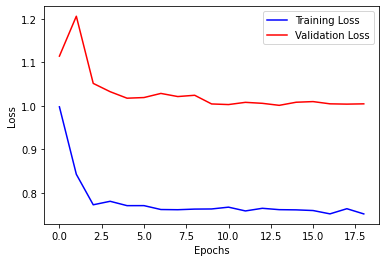

In [207]:
loss = history.history["loss"]
validation_loss = history.history["val_loss"]
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss , 'b', label="Training Loss")
plt.plot(epochs,validation_loss, 'r', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

2/2 [==============================] - 0s 11ms/step


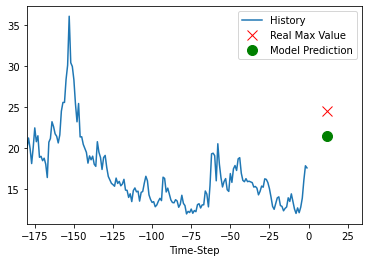

2/2 [==============================] - 0s 12ms/step


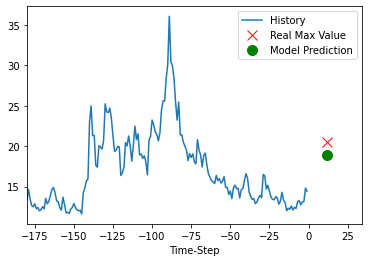

2/2 [==============================] - 0s 12ms/step


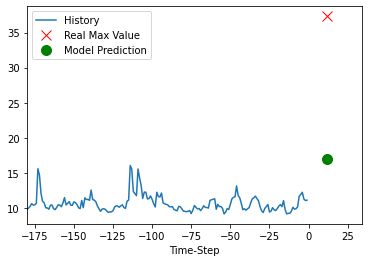

2/2 [==============================] - 0s 11ms/step


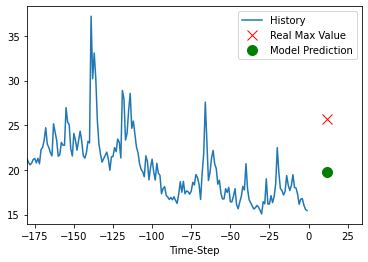

1/1 [==============================] - 0s 262ms/step


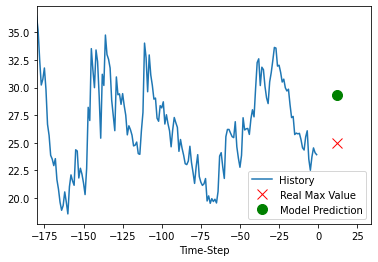

In [212]:
def show_plot(plot_data, delta):
    labels = ["History", "Real Max Value", "Model Prediction"]
    marker = ["-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

def de_normalize(output_data, mean, std):
    return output_data * std + mean

for x, y in data_train_validation.shuffle(10000).take(5):
    show_plot([de_normalize(x[0].numpy(), meann, stdd),de_normalize(y[0].numpy(), meann, stdd),de_normalize(model.predict(x)[0], meann, stdd)],12)
